In [ ]:
!pip install google-cloud-automl
!pip install google-cloud-storage
!pip install opencv-python==3.3.0.9
!pip install keras
!pip install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl

In [1]:
def colour_frame(img, frame, width=3, colour=[0, 0, 0]):
    """"""
    x1, y1, x2, y2 = frame['box_points']
    img[y1:y2, x1:x1+width] = colour
    img[y1:y2, x2-width:x2] = colour
    img[y1:y1+width, x1:x2] = colour
    img[y2-width:y2, x1:x2] = colour
    return img


def colour_map(shelf):
    MAP = {0: [255, 0, 0], 1: [0, 0, 255], 2: [0, 255, 0], 3: [0, 255, 255], 4: [255, 255, 0], 5: [28,128,128]}
    return MAP.get(shelf % len(MAP))


def compute_dominance_relations(detections):
    """"""
    for i, frame in enumerate(detections):
        x1, y1, x2, y2 = frame['box_points']
        for j, frame_ in enumerate(detections):
            x1_, y1_, x2_, y2_ = frame_['box_points']
            if y2 < y1_:
                dominated_by = frame_.setdefault('dominated_by', set())
                dominated_by.add(i)


def compute_seed_shelves(detections):
    """"""
    frame_indeces = {i for i in range(len(detections))}    
    shelf = 0
    shelves = []
    while frame_indeces:
        shelf_frames = set()      
        for i in frame_indeces:
            frame = detections[i]
#            current_frame = colour_frame(main_obj, frame)
#            Image.fromarray(current_frame, 'RGB').show()
            dominated_by = (detections[i] for i in frame.get('dominated_by', {}))
            if all(dominating_frame.get('shelf', float('inf')) <= shelf 
                   for dominating_frame in dominated_by):
                frame['shelf'] = shelf + 1
                shelf_frames.add(i)
#                main_obj = colour_frame(main_obj, frame, colour=colour_map(shelf))
#                img = Image.fromarray(main_obj, 'RGB')
        shelves.append(shelf_frames)
        frame_indeces -= shelf_frames
        shelf += 1
    return shelves
       
 
def mean_bottom_polishing(shelves, detections, main_obj):
    """"""
    def mean_bottom_polishing_(shelves, detections):
        shelf = 0
        for shelf_frames in shelves[:-1]:
            lower_shelf_frames = shelves[shelf+1]
            shelf_bottoms = [detections[i]['box_points'][3] for i in shelf_frames]
            avg_bottom = np.mean(shelf_bottoms)
            to_be_merged = set()
            for i in lower_shelf_frames:
                if avg_bottom > detections[i]['box_points'][1]:
                    detections[i]['shelf'] = shelf
                    to_be_merged.add(i)  
            shelf_frames |= to_be_merged  
            lower_shelf_frames -= to_be_merged
    
            shelf += 2 if to_be_merged else 1
            if shelf >= len(shelves) - 1:
                break 
        return [shelf for shelf in shelves if shelf]
    
    while True: 
        shelves2 = shelves.copy()  
        main_obj = colour_shelves(shelves, detections, main_obj)
#        Image.fromarray(main_obj, 'RGB').show()
        shelves = mean_bottom_polishing_(shelves, detections)
        if shelves == shelves2:
            return shelves
    
    
def polish_nonshlef_frames(shelves, detections):
    for ishelf in range(len(shelves[:-1])):
        shelf = shelves[ishelf]
        lower_shelf = shelves[ishelf+1]
        to_remove = {i for i in shelf if not all(i in detections[j].get('dominated_by', {}) for j in lower_shelf)}
        if to_remove:
            shelf -= to_remove
            for i in to_remove:
                detections[i].pop('shelf')
    return shelves


def detect_shelves(detection, main_obj):
    """
    Input
    -----
    detections : list
        detected frames provided by `ObjectDetection`
    main_obj : image
        original image with colored `detection` provided by `ObjectDetection`
    
    Returns
    -------
    shelves : list of shelves (top-down) 
        with each shelf as a set of respective frame-indices pointing to `detections`
    main_obj : image
        original image with colored shelves   
    """
    compute_dominance_relations(detections)   

    shelves = compute_seed_shelves(detections)

    shelves = mean_bottom_polishing(shelves, detections, main_obj)
    
#    shelves = polish_nonshlef_frames(shelves, detections)     
       
    main_obj = colour_shelves(shelves, detections, main_obj)

    return shelves, main_obj


def colour_shelves(shelves, detections, main_obj):
    """"""
    for i, shelf in enumerate(shelves):
        for iframe in shelf:
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(i))
    return main_obj
  
def colour_shelves_prediction(shelves, detections, main_obj):
    """"""
    for i, shelf in enumerate(shelves):
        for iframe in shelf:
          if detections[iframe]['class'] == 'RB':
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(2))
          elif detections[iframe]['class'] == 'RBsf':
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(4))
          else: 
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(5))
    return main_obj
  
def blur_image(image, amount=5):
    '''Blurs the image
    Does not affect the original image'''
    kernel = np.ones((amount, amount), np.float32) / (amount**2)
    return cv2.filter2D(image, -1, kernel)

In [1]:
from google.cloud import automl_v1beta1# Imports the Google Cloud client library
from google.cloud.automl_v1beta1.proto import service_pb2
from google.cloud import storage
from IPython.display import Image
from PIL import Image as Img
import io
import numpy as np
import math
import cv2
import glob

# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = 'saleshousephotos'

bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs()

#photos = []
#for blob in blobs:
#  if 'photos/image' in blob.name:
#    photos.append(blob.name)
#photos = photos[1:]
  
#tmp = bucket.blob(photos[-1]).download_as_string()
#image = np.array(Img.open(io.BytesIO(tmp)))
#print(True)
"./test_write.jpg"

ContextualVersionConflict: (google-api-core 0.1.4 (/usr/local/envs/py3env/lib/python3.5/site-packages), Requirement.parse('google-api-core[grpc]<2.0.0dev,>=1.1.0'), {'google-cloud-automl'})

In [3]:
from imageai.Detection import ObjectDetection
PERC = 15

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("./temp_model.h5")
detector.loadModel()

custom_objects = detector.CustomObjects(person=False, car=False, bottle = True)
main_obj, detections, extracted_obj = detector.detectCustomObjectsFromImage(input_image= image, 
                                                    input_type="array",
                                                    #output_type="file",
                                                    output_type = 'array', 
                                                    output_image_path= "./im.png", 
                                                    custom_objects=custom_objects,
                                                    extract_detected_objects=True,
                                                    minimum_percentage_probability=15)
        
shelves, main_obj = detect_shelves(detections, main_obj)
print(True)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


True


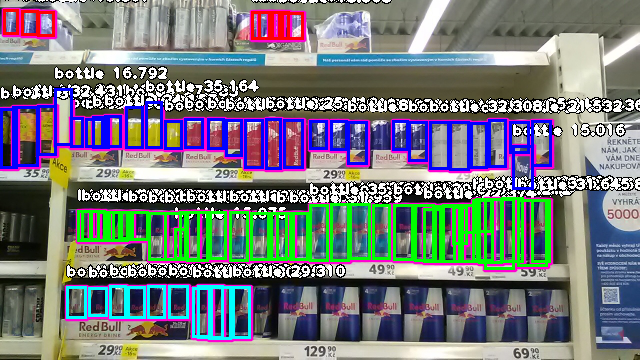

In [4]:
img = Img.fromarray(main_obj, 'RGB')
img

In [5]:
prediction_client = automl_v1beta1.PredictionServiceClient()
project_id = 'saleshouse-prototype'
model_id = 'ICN4760874677604180454'
name = 'projects/{}/locations/us-central1/models/{}'.format(project_id, model_id)
print(True)

True


In [6]:
tmp = [(0,0) for i in range(len(detections))]
class_tuples = {'RB': tmp, 'RBsf':tmp}
class_names = class_tuples.keys()
for e in range(len(extracted_obj)):
  cv2.imwrite("./img1.jpg", extracted_obj[e])
  with open("./img1.jpg", 'rb') as ff:
    content = ff.read()
  payload = {'image': {'image_bytes': content }}
  params = {}
  request = prediction_client.predict(name, payload, params)
  detections[e]['class'] = request.payload[0].display_name
  if detections[e]['class'] in class_names:
    class_tuples[detections[e]['class']][e] = (detections[e]['box_points'][0],detections[e]['box_points'][2])

In [7]:
main_obj = colour_shelves_prediction(shelves, detections, main_obj)

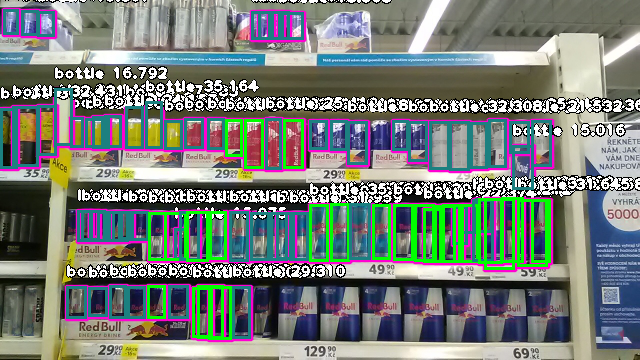

In [8]:
sz = main_obj.shape[1]
img = Img.fromarray(main_obj, 'RGB')
img

In [9]:
sz = main_obj.shape[1]
for clss in class_names:
  for k in range(len(shelves)):
    shelf_tuple = [class_tuples[clss][l] for l in shelves[k]]
    sorted_by_lower_bound = sorted(shelf_tuple, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
      if not merged:
          merged.append(higher)
      else:
          lower = merged[-1]
          if higher[0] <= lower[1]:
              upper_bound = max(lower[1], higher[1])
              merged[-1] = (lower[0], upper_bound)  # replace by merged interval
          else:
              merged.append(higher)
    zastoupeni = sum([i[1] - i[0] for i in merged])/sz 
    print(clss, k, zastoupeni)

RBsf 0 0.0
RBsf 1 0.0921875
RBsf 2 0.4625
RBsf 3 0.0921875
RB 0 0.0
RB 1 0.0921875
RB 2 0.4625
RB 3 0.0921875


In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 250, 250)
image = blur_image(edges, amount = 7)

lines = cv2.HoughLinesP(image, rho = 1, theta = math.pi, threshold = 20, minLineLength = img.shape[0]/1.5, maxLineGap = 0)

if lines is None:
  #  image = blur_image(edges, amount = 7)
    lines = cv2.HoughLinesP(image, rho = 1, theta = math.pi, threshold = 50, minLineLength = img.shape[0]/2.5, maxLineGap = 3)

img2 = img.copy()
lines = sorted(lines,key=lambda x: x[0,0])
dominance = -1000
for line2 in range(len(lines)):
    line = lines[line2]
    if line[0,0] - dominance > 0.2*img.shape[1]:
        if (line[0,0] < 0.2*img.shape[1] or line[0,0] > 0.8*img.shape[1]):        
            pt1 = (line[0,0],line[0,1])
            pt2 = (line[0,2],line[0,3])
            cv2.line(img, pt1, pt2, (0,0,255), 3)
            dominance = line[0,0]
    pt1 = (line[0,0],line[0,1])
    pt2 = (line[0,2],line[0,3])
    cv2.line(img2, pt1, pt2, (0,0,255), 3)
#cv2.imwrite('/Users/jakubstech/Documents/compvis/image26lines.jpg', img)
Image.fromarray(img).show()
Image.fromarray(img2).show()